# Multiclass Classification For User Complaints in Banking

## Introduction
This is an NLP-based problem solving approach for the dataset available at https://catalog.data.gov/dataset/consumer-complaint-database for consumer-complaint database for the Banking sector. It contains 1,179,715 rows and 18 columns.

This notebook is an attempt to solve a prediction problem with 'Product' as the label and 'Consumer complaint narrative' as
input. After looking at the features, I decided to go ahead with only these two features and dropped the others.
The reason for not taking other columns - Issue and sub-issue would actually try to give away the product easily. Company public response is like a categorical variable with 11 possible values. But I don't believe that can help classify the nature of complaints. Similarly for Tags, Consumer consent provided, Submitted via, Date sent to company and others.

In [1]:
import nltk
import pickle
import gensim
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.corpus import wordnet as wn
from stop_words import get_stop_words
import re, sys, math, string
import calendar as cal
import numpy as np
from ast import literal_eval
import logging
from gensim.models import word2vec
#from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from  sklearn.calibration import CalibratedClassifierCV
from keras.layers import Embedding
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.layers import Input, Dense, Embedding, Conv2D, MaxPooling2D, Dropout,concatenate
from keras.layers.core import Reshape, Flatten
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.models import Model
from keras import regularizers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from gensim.models.keyedvectors import KeyedVectors
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import altair as alt
from collections import Counter
from numpy  import array
import seaborn as sns
#logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',level=logging.INFO)

main_df = pd.read_csv('data/Consumer_Complaints.csv')

# creating a list of extra stop-words as these repeatedly appear in all complaints
# xxxx is used in the data to hide sensitive information
stplist = ['title', 'body', 'xxxx']
english_stopwords = get_stop_words(language='english')
english_stopwords += stplist
english_stopwords = list(set(english_stopwords))

def get_wordnet_pos(word):
    """
    Function that determines the the Part-of-speech (POS) tag.
    Acts as input to lemmatizer
    """
    if word.startswith('N'):
        return wn.NOUN
    elif word.startswith('V'):
        return wn.VERB
    elif word.startswith('J'):
        return wn.ADJ
    elif word.startswith('R'):
        return wn.ADV
    else:
        return wn.NOUN


def clean_up(text):
    """
    Function to clean data.
    Steps:
    - Removing special characters, numbers
    - Lemmatization
    - Stop-words removal
    - Getting a unique list of words
    - TODO: try removing names and company names like Navient (Proper nouns)
    """
    #lemma = WordNetLemmatizer()
    lemmatizer = nltk.WordNetLemmatizer().lemmatize
    text = re.sub('\W+', ' ', str(text))
    text = re.sub(r'[0-9]+', '', text.lower())
    # correcting spellings of words using TextBlob - user complaints are bound to have spelling mistakes
    # However, this idea was later dropped because TextBlob may change the words.
    # text = TextBlob(text).correct()
    word_pos = nltk.pos_tag(nltk.word_tokenize(text))
    normalized_text_lst = [lemmatizer(x[0], get_wordnet_pos(x[1])).lower() for x in word_pos]
    stop_words_free = [i for i in normalized_text_lst if i not in english_stopwords and len(i) > 3]
    stop_words_free = list(set(stop_words_free))
    return(stop_words_free)


def get_average_word2vec(complaints_lst, model, num_features=300):
    """
    Function to average the vectors in a list.
    Say a list contains 'flower' and 'leaf'. Then this function gives - model[flower] + model[leaf]/2
    - index2words gets the list of words in the model.
    - Gets the list of words that are contained in index2words (vectorized_lst) and 
      the number of those words (nwords).
    - Gets the average using these two and numpy.
    """
    #complaint_feature_vecs = np.zeros((len(complaints_lst),num_features), dtype="float32") #?used?
    index2word_set = set(model.wv.index2word)
    vectorized_lst = []
    vectorized_lst = [model[word] if word in index2word_set else np.zeros(num_features) for word in \
                      complaints_lst]    
    nwords = len(vectorized_lst)
    summed = np.sum(vectorized_lst, axis=0)
    averaged_vector = np.divide(summed, nwords)
    return averaged_vector

c:\users\skaurtakkar\appdata\local\programs\python\python36\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Using TensorFlow backend.


## Basic EDA
I would have liked to do more plots such as TSNE for word2Vec model which is generated later on and finding out most frequently used words, most frequently mis-spelled words, category-wise exploration of words.
I would have also liked to do PCA and display the results as plots in 2-dimensional plane to visualize the word models.
As can be seen, classes are highly imbalanced.

In [79]:
df = main_df
df = df[['Product', 'Consumer complaint narrative']]

# Removing values which don't have 'Consumer complaint narrative' field. As this is the main field used for NLP 
# work. - 348,928 columns with not null consumer complaints.
df = df[pd.notnull(df['Consumer complaint narrative'])]
df = df.rename({'Consumer complaint narrative':'complaint', 'Product':'product'},
               axis='columns')

products_count_df = df.groupby('product').complaint.count().to_frame()
products_count_df.reset_index(level=0, inplace=True)


values = np.array([2,5,3,6,4,7,1])   
idx = np.array(df['product']) 
clrs = ['grey' if (x < max(values)) else 'red' for x in values ]
sb.barplot(x=idx, y=values, palette=clrs) # color=clrs)


alt.Chart(products_count_df).mark_bar().encode(
    x='product:O',
    y="complaint:Q",
    color=alt.condition(
        alt.datum.product == 'Debt collection',
        alt.value('orange'),  
        alt.value('steelblue')   
    )
).properties(width=550)

There is imbalance in data. Virtual currency type of complaints are 16 in number while debt collection complaints
are a total of 79522. This can be seen in the plot below.
This can be dealt with my up-sampling the under-represented classes by say, bootstrapping and sampling techniques, or by some similar word generation algorithm, which may generate synthetic cases.

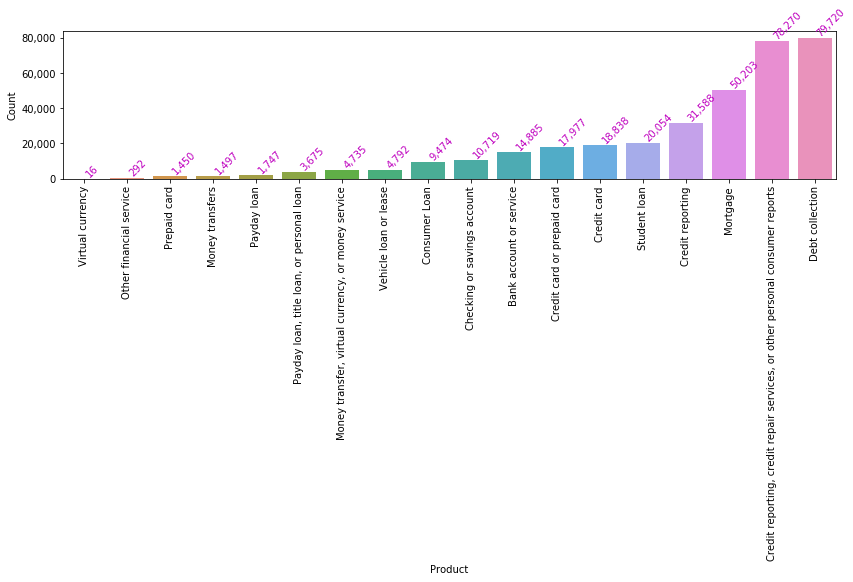

In [87]:
plt.figure(figsize=(12,8))
# plot barh chart with index as x values
ax = sns.barplot(products_count_df['product'], products_count_df['complaint'])
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
ax.set(xlabel="Product", ylabel='Count')
ax.set_xticklabels(products_count_df['product'])
for item in ax.get_xticklabels(): item.set_rotation(90)
for i, v in enumerate(products_count_df["complaint"].iteritems()):        
    ax.text(i ,v[1], "{:,}".format(v[1]), color='m', va ='bottom', rotation=45)
plt.tight_layout()
plt.show()

## Preprocessing of Data

Dealing with date - Removed after these considerations:
1. The model accuracy wasn't getting affected a lot. Only by a few decimal places.
2. Some models don't take negative values
Code for handling date is commented out.

Up-sampling would help in this case, to increase the number of instances of classes like 'Virtual currency' and 'Other financial services' as these have very less cases.

In [3]:
# df['year'] = df['received_dt'].str.slice(6, 10).astype(int)
# df['day'] = df['received_dt'].str.slice(3, 5).astype(int)
# df['month'] = df['received_dt'].str.slice(0, 2).astype(int)

# # calculate and check these values once -- !! --
# df['sin_day'] = np.sin(2*np.pi*(df['day'] - 1)/np.vectorize(calc_monthrange)(df['year'], df['month']))
# df['cos_day'] = np.cos(2*np.pi*(df['day'] - 1)/np.vectorize(calc_monthrange)(df['year'], df['month']))

# df['sin_month'] = np.sin(2*np.pi*(df['month'] - 1)/12)
# df['cos_month'] = np.cos(2*np.pi*(df['month'] - 1)/12)

# drop_columns = ['received_dt', 'year', 'month', 'day', ]
# df.drop(drop_columns, inplace=True, axis=1)

# ---
# The next two lines take some time to run because they are cleaning each row of the text.
# I saved this dataframe and now, I'm loading the same here.
# df['complaint'] = df['complaint'].apply(clean_up)
# df.to_csv("data/modified/output_consumer_complaints.csv", index=False)
# ---

# Loading this from the saved version of this file.
input_df = pd.read_csv('data/modified/output_consumer_complaints.csv', 
                       converters={"complaint": literal_eval}) #to fetch date as a list
input_df.head()

,product,complaint
0,Student loan,"[credit, student, company, bring, keep, delinq..."
1,Credit card or prepaid card,"[account, sign, monitoring, access, capital, p..."
2,Mortgage,"[link, speak, collect, corporate, advertising,..."
3,Mortgage,"[respond, finally, wait, upon, safe, discount,..."
4,Credit reporting,"[credit, find, significant, please, last, help..."


In [4]:
# Some rows have been stripped of words after the cleaning process and contain empty lists
# These have to be removed as they don't help in the prediction problem at all.
# Moreover, they produce NaNs after going through word2Vec, giving a vector of 300 (num_of_features) NaNs each.
print("Removing rows which have been stripped of words after the cleaning process. These contain empty lists:")
print("Before: ", input_df.shape)
input_df = input_df[input_df.astype(str)['complaint'] != '[]']
print("After: ", input_df.shape)
# 14 rows removed in total.
bow_input_df = input_df

Removing rows which have been stripped of words after the cleaning process. These contain empty lists:
Before:  (349932, 2)
After:  (349918, 2)


## Technique I: Bag of Words Model (CountVectorizer)

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from numpy import array

min_word_count = 10
products_count_df = bow_input_df.groupby('product').complaint.count().to_frame()
products_count_df.reset_index(level=0, inplace=True)
class_labels = array(products_count_df['product'].unique())

In [6]:
# TfidfVectorizer handles tokenization.
bow_input_df['complaints_untokenized'] = bow_input_df['complaint'].apply(lambda x: ' '.join(x))

# Goes out of memory without max_features on p2.xlarge. I tried to increase max_features but the memory error 
# wouldn't allow me.
tfidf_converter = TfidfVectorizer(max_features=1500, sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', 
                                  stop_words='english')
features = tfidf_converter.fit_transform(bow_input_df.complaints_untokenized).toarray()
labels = class_labels
# Naive Bayes takes only non-negative values. So not adding the date features to the model.

In [55]:
ktrain_x, ktest_x, ktrain_y, ktest_y = train_test_split(bow_input_df['complaints_untokenized'], bow_input_df['product'], 
                                                        test_size=0.3, random_state=123)

# Used later for keras.
train_df = pd.concat([pd.DataFrame(ktrain_x), pd.DataFrame(ktrain_y, columns=["product"])], axis=1)      
val_df = train_df.sample(frac=0.2,random_state=200)
test_df = pd.concat([pd.DataFrame(ktest_x), pd.DataFrame(ktest_y, columns=["product"])], axis=1)

#texts = train_df.complaint
print(val_df.shape)
print(train_df.shape)
print(test_df.shape)

(48988, 2)
(244942, 2)
(104976, 2)


## Training and Test Sets

In [44]:
train_x, test_x, train_y, test_y = train_test_split(features, bow_input_df['product'], test_size=0.3,
                                                    random_state=123)

## Modelling
The TF-IDF model used only allows a limited number of words to be chosen as the features. Going beyond that gives an out-of-memory error. Given that this limit reduces the feature space, the results expected would be better with more memory power.

Models that I implemented:

1. Naive Bayes: Simple and can work pretty well.
2. Random Forest: It is known to perform quite well by using dumb classfiers to build a powerful learning model
3. Linear SVM: Seemed to perform well on examples online.

Given more time, I would have tried Logistic Regression, Radial SVM, Neural nets, etc.

In [8]:
# Model 1: Naive Bayes model
bayes_model = MultinomialNB()
bayes_clf = bayes_model.fit(train_x, train_y)

In [9]:
naive_preds = bayes_clf.predict(test_x)
naive_preds_conf = bayes_clf.predict_proba(test_x)
naive_preds_conf_df = pd.DataFrame(naive_preds_conf, index=range(naive_preds_conf.shape[0]),
                          columns=range(naive_preds_conf.shape[1]))
naive_preds_conf_df['predicted_conf'] = naive_preds_conf_df.max(axis=1)
naive_results = pd.DataFrame(data={"actual_label":test_y, "predicted_label":naive_preds})

naive_results = pd.concat([naive_results, naive_preds_conf_df['predicted_conf']], axis=1)
# Accuracy: wherever the labels were correctly predicted.
naive_results['correctly_predicted'] = np.where(naive_results['actual_label'] == naive_results['predicted_label'], 
                                                1, 0)
naive_accuracy = (naive_results['correctly_predicted'].sum()/naive_results.shape[0])*100
print("Accuracy of Naive Bayes is: {0:.2f}.".format(naive_accuracy))
# 37.78 with 1500 features

Accuracy of Naive Bayes is: 37.03.


In [10]:
print(metrics.classification_report(test_y, naive_preds, target_names=bow_input_df['product'].unique()))

                                                                              precision    recall  f1-score   support

                                                                Student loan       0.46      0.59      0.52      4346
                                                 Credit card or prepaid card       0.62      0.16      0.25      3198
                                                                    Mortgage       0.48      0.21      0.29      2841
                                                            Credit reporting       0.48      0.39      0.43      5671
Credit reporting, credit repair services, or other personal consumer reports       0.45      0.31      0.37      5452
                                                             Debt collection       0.74      0.06      0.11      9440
                                                       Vehicle loan or lease       0.56      0.81      0.66     23573
                          Money transfer, virtual curre

In [11]:
# Model 2: Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators = 100, max_features='sqrt', verbose=1, warm_start=False,
                                 random_state=123) #ntrainDataVecs=4, max_depth=2)
rf_clf = rf_model.fit(train_x, train_y)
rf_preds = rf_clf.predict(test_x)
rf_preds_conf = rf_clf.predict_proba(test_x)
rf_preds_conf_df = pd.DataFrame(rf_preds_conf, index=range(rf_preds_conf.shape[0]),
                          columns=range(rf_preds_conf.shape[1]))

rf_preds_conf_df['predicted_conf'] = rf_preds_conf_df.max(axis=1)
rf_results = pd.DataFrame(data={"actual_label":test_y, "predicted_label":rf_preds})
rf_results = pd.concat([rf_results, rf_preds_conf_df['predicted_conf']], axis=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  7.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    7.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    9.0s finished


In [12]:
# Accuracy: wherever the labels were correctly predicted.
rf_results['correctly_predicted'] = np.where(rf_results['actual_label'] == rf_results['predicted_label'], 1, 0)
rf_accuracy = (rf_results['correctly_predicted'].sum()/rf_results.shape[0])*100
print("Accuracy of Random Forest obtained is: {0:.2f}.".format(rf_accuracy))
print(metrics.classification_report(test_y, rf_preds, target_names=bow_input_df['product'].unique()))

Accuracy of Random Forest obtained is: 41.49.
                                                                              precision    recall  f1-score   support

                                                                Student loan       0.46      0.62      0.53      4346
                                                 Credit card or prepaid card       0.49      0.21      0.29      3198
                                                                    Mortgage       0.48      0.24      0.32      2841
                                                            Credit reporting       0.48      0.45      0.46      5671
Credit reporting, credit repair services, or other personal consumer reports       0.48      0.38      0.42      5452
                                                             Debt collection       0.82      0.32      0.46      9440
                                                       Vehicle loan or lease       0.68      0.88      0.77     23573
         

In [13]:
# Model 3: Linear Support Vector Machine
svc_model = LinearSVC()
svcc_model = CalibratedClassifierCV(svc_model)     
svc_clf = svcc_model.fit(train_x, train_y)
svc_preds = svcc_model.predict(test_x)
svc_preds_conf = svcc_model.predict_proba(test_x)
svc_preds_conf_df = pd.DataFrame(svc_preds_conf, index=range(svc_preds_conf.shape[0]), 
                                columns=range(svc_preds_conf.shape[1]))
svc_preds_conf_df['predicted_conf'] = svc_preds_conf_df.max(axis=1)
svc_results = pd.DataFrame(data={'actual_label':test_y, 'predicted_label':svc_preds})

svc_results = pd.concat([svc_results, svc_preds_conf_df['predicted_conf']],axis=1)

In [14]:
# Accuracy: wherever the labels were correctly predicted.
svc_results['correctly_predicted'] = np.where(svc_results['actual_label'] == svc_results['predicted_label'], 1, 0)
svc_results.head()
svc_accuracy = (svc_results['correctly_predicted'].sum()/svc_results.shape[0])*100
print("Accuracy of Linear SVC obtained is: {0:.2f}.".format(svc_accuracy))
print(metrics.classification_report(test_y, svc_preds, target_names=bow_input_df['product'].unique()))

Accuracy of Linear SVC obtained is: 40.01.
                                                                              precision    recall  f1-score   support

                                                                Student loan       0.51      0.56      0.53      4346
                                                 Credit card or prepaid card       0.50      0.35      0.42      3198
                                                                    Mortgage       0.47      0.34      0.39      2841
                                                            Credit reporting       0.49      0.50      0.49      5671
Credit reporting, credit repair services, or other personal consumer reports       0.50      0.41      0.45      5452
                                                             Debt collection       0.57      0.30      0.39      9440
                                                       Vehicle loan or lease       0.63      0.74      0.68     23573
            

#### Comparison between the models implemented
- Of the Bag of Words models implemented, Random Forest performs the best with an accuracy of 41.49%.
- As the number of features are limited in this Bag of Words model, this is expected. Sometimes, the Bag of Words model can outperform techniques like Word2Vec. However, in my case, limiting the number of features is putting a damper on the accuracy.

#### Accuracies
- Naive Bayes - 37.03
- Random Forest - 41.49
- Linear SVC - 40.01

-----------------------------------------------------------------------------------------------------------------

## Technique 2: Word2Vec
I tried creating my own model for Word2Vec. However, this only contained 17million words, as opposed to Google's GoogleNews' pretrained Word2Vec model. So, I chose to go ahead with the pre-trained model.
In lieu of time, I couldn't do this - but I would have preferred to complement the Google Word2Vec model with words from this dataset. This Word2Vec model is up until 2013, post which slang/other important words might have been introduced in the vocabulary. 
Of course, these words could also be company-complaint specific. For example, for ATB Bank, someone might be using ATB bank or a specific Policy name like ATBUltraInsurance. These would also be removed.
Apart from this, these complaints contain a lot of spelling mistakes and words joined together. Such as: `immeditalely`, `demaging`,  `practiciing`, etc. (shown as missing_words in the cells below), and two words joined together into one word, such as 'givenrequesting'.
I tried looking into it and found out about a library called TextBlob. However, people also warned against its used because it might not always be right. So I chose to not use it and skip over these words for now.
There were also short forms not detected by the model.

In [15]:
# Creating a Word2Vec model using training set
vocabulary_of_all_words = input_df['complaint'].tolist()
num_features = 300
min_word_count = 10                      
num_workers = 8
context = 10          # Context window size                                                                                    
downsampling = 1e-3   # Downsampling for frequent words
word2vec_model_name = "trained_models/300features_10minwords_10context"
word2vec_complaints = word2vec.Word2Vec(vocabulary_of_all_words, workers=num_workers, size=num_features, 
                                   min_count=min_word_count, window=context, sample=downsampling)
word2vec_complaints.save(word2vec_model_name)

In [16]:
# Fetching trained model to save time.
word2vec_complaints = gensim.models.Word2Vec.load(word2vec_model_name)

In [17]:
vocab_lst_flat = [item for sublist in vocabulary_of_all_words for item in sublist]
vocab_lst_flat = list(set(vocab_lst_flat))
# Loading a pre-trained GoogleNews model
# word2vec_model = KeyedVectors.load_word2vec_format("trained_models/GoogleNews-vectors-negative300.bin", binary=True)

In [18]:
# Exploring this model to see how well it has trained and checking for spelling mistakes in user-complaints
try:
    word2vec_complaints.wv.most_similar("good")
except KeyError:
    print("Sorry, this word doesn't exist in the vocabulary.")
    
words_not_present = 0
words_present = 0
total_unique_tokens = len(set(vocab_lst_flat))
missing_words = []
for i in vocab_lst_flat:
    try:
        p = word2vec_complaints[i]
        words_present+=1
    except KeyError:
        missing_words.append(i)
        words_not_present+=1
print(words_present, words_not_present, total_unique_tokens)

14678 78574 93252


In [19]:
# Examples of spelling mistakes, grammatical errors, etc.
print(missing_words[:20])

['messagecould', 'veheicle', 'cocc', 'foreclosurebecause', 'emancipate', 'derogatorystatus', 'thon', 'paypaltransaction', 'mywallet', 'awere', 'utilitie', 'disputeafter', 'nastu', 'warfeild', 'fhea', 'ppeared', 'equalfor', 'xxxxxxxxtele', 'emergycare', 'maitance']


#### Analyzing the Word2Vec Model
- The Google word2vec model isn't able to account for a lot of words. It can be made better by retraining on more words from the training set available to us. However, a lot of these words are spelling mistakes. So the question would be - how to choose the right set of words to re-train this Google's model over?
- More libraries which fix the spelling of words can be explored only for those cases which are being missed out by the model (represented by missing_words list above). However, again, fixing a spelling mistake can be fickle.
- The presence of 'xxxx', 'xx', etc. in various forms is a simple fix which can also be implemented in the training set.
- Initially, I had planned to use Google's pretrained Word2Vec model to represent my training set. However, after waiting for hours for training on Google word2vec model, I switched back to the Word2Vec model for want of speed.

In [20]:
# ---
# # These take a very long time to be averaged. Commenting this code and reading from file the saved output.
# ---
# embeddings_df = input_df['complaint'].apply(lambda complaint: get_average_word2vec(complaint, word2vec_complaints, 
#                                                                                    num_features)).to_frame()
# col_lst = []
# for i in range(num_features):
#     col_lst.append('vec_'+str(i+1))
# # Easy to write to file and process when exploded into columns
# exploded_em_df = pd.DataFrame(embeddings_df.complaint.tolist(), columns=col_lst)
# exploded_em_df = pd.DataFrame(embeddings_df)['complaint'].apply(pd.Series)
# exploded_em_df.head()
# exploded_em_df.to_csv("data/modified/vocab_trained_word2Vec.csv", index=False)

In [21]:
exploded_em_df = pd.read_csv('data/modified/vocab_trained_word2Vec.csv')
print("Word2Vec output:\n")
exploded_em_df.head()

Word2Vec output:



,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.044390,0.431329,-0.037583,-0.562910,0.749886,0.563165,-0.218987,-0.017564,0.008727,0.013138,...,-0.381942,0.378966,0.306838,-0.294844,0.248955,0.041946,0.314764,0.286428,-0.137486,-0.029800
1,-0.449600,-0.235843,-0.234160,0.773755,0.219879,-1.025284,-1.374882,1.774549,-0.589765,-0.588578,...,0.354155,-0.708604,-0.800504,0.057327,-0.745757,-0.106576,0.370323,0.025995,-0.415189,-0.014639
2,-0.153348,0.059681,-0.206620,0.199658,-0.445544,-0.407167,0.237810,0.023530,-0.311680,0.213545,...,-0.189978,0.126637,-0.329037,0.285830,0.130250,0.066599,-0.215613,-0.107374,-0.617056,-0.336326
3,0.046049,0.213279,0.048666,0.105835,0.053492,-0.279306,-0.165885,-0.058923,-0.165988,-0.173027,...,-0.086508,0.125770,0.042836,0.062695,0.029828,-0.118284,0.175451,-0.025208,-0.321435,-0.064858
4,-0.106485,0.073293,0.432965,-1.741339,-0.102293,0.255682,1.212548,-0.572600,0.216459,-0.829040,...,0.504210,0.034536,-0.222651,0.308653,-0.113117,-0.050028,0.157179,0.222842,-0.037337,-0.240833


In [22]:
input_df = input_df.reset_index(drop=True)
vectorized_df = pd.concat([exploded_em_df, input_df[['product']]], axis=1)                        
vectorized_df = shuffle(vectorized_df)

if vectorized_df[vectorized_df.isnull().any(axis=1)].empty:
    res = "True" # No NaNs exist in the cleaned dataset.
else:
    res = "False"
print(res)
print(vectorized_df.shape)
if not res:
    vectorized_df[vectorized_df.isnull().any(axis=1)]
    vectorized_df.dropna(axis=0, how='any')
    print(vectorized_df.shape)

True
(349918, 301)


### Training and Test Sets

In [56]:
vectorized_data = np.array(vectorized_df.drop('product', axis=1))
vectorized_target = np.array(vectorized_df['product'])

train_x, test_x, train_y, test_y = train_test_split(vectorized_data, vectorized_target,
                                                    test_size=0.3,
                                                    random_state=123)

### Modelling
Some of the models that I tried:
1. Random Forest Classifier: It is known to perform quite well by using dumb classfiers to build a powerful learning model
2. Linear SVC: Seemed to perform well on examples online.
3. Deep Neural Network - CNN: Upon reading online some discussion on this, I thought of implementing CNNs. It said - what has recently been shown to work much better and simpler than RNNs is using word vectors, pre-trained on a large corpus, as features to the neural network. RNNs were called 'slow and fickle to train'. 

In [24]:
# Model 1: Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators = 100, max_features='sqrt', verbose=1, warm_start=False,
                                 random_state=123) #ntrainDataVecs=4, max_depth=2)
rf_clf = rf_model.fit(train_x, train_y)
rf_preds = rf_clf.predict(test_x)
rf_preds_conf = rf_clf.predict_proba(test_x)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 11.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    6.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    6.0s finished


In [25]:
rf_preds_conf_df = pd.DataFrame(rf_preds_conf, index=range(rf_preds_conf.shape[0]),
                          columns=range(rf_preds_conf.shape[1]))
rf_preds_conf_df['predicted_conf'] = rf_preds_conf_df.max(axis=1)
rf_results = pd.DataFrame(data={"actual_label":test_y, "predicted_label":rf_preds})

rf_results = pd.concat([rf_results, rf_preds_conf_df['predicted_conf']],
                          axis=1)
# Accuracy: wherever the labels were correctly predicted.
rf_results['correctly_predicted'] = np.where(rf_results['actual_label'] == rf_results['predicted_label'], 1, 0)
rf_accuracy = (rf_results['correctly_predicted'].sum()/rf_results.shape[0])*100

Accuracy of Random Forest obtained is: 65.30.


In [64]:
# Accuracy: wherever the labels were correctly predicted.
rf_results['correctly_predicted'] = np.where(rf_results['actual_label'] == rf_results['predicted_label'], 1, 0)
rf_accuracy = (rf_results['correctly_predicted'].sum()/rf_results.shape[0])*100
print("Accuracy of Random Forest obtained is: {0:.2f}.".format(rf_accuracy))
print(metrics.classification_report(test_y, rf_preds, target_names=bow_input_df['product'].unique()))

Accuracy of Random Forest obtained is: 65.30.
                                                                              precision    recall  f1-score   support

                                                                Student loan       0.41      0.51      0.45      4455
                                                 Credit card or prepaid card       0.32      0.16      0.21      3202
                                                                    Mortgage       0.47      0.04      0.08      2962
                                                            Credit reporting       0.40      0.34      0.37      5610
Credit reporting, credit repair services, or other personal consumer reports       0.37      0.30      0.33      5354
                                                             Debt collection       0.80      0.24      0.37      9373
                                                       Vehicle loan or lease       0.63      0.88      0.74     23410
         

In [27]:
# Model 2: Linear Support Vector Machine
svc_model = LinearSVC()
# CV = 5
# accuracy = cross_val_score(svc_model, train_x, train_y, scoring='accuracy', cv=CV)
# accuracy.mean() - obtained was 64.29%
svcc_model = CalibratedClassifierCV(svc_model)     
svc_clf = svcc_model.fit(train_x, train_y)

In [28]:
svc_preds = svcc_model.predict(test_x)
svc_preds_conf = svcc_model.predict_proba(test_x)
svc_preds_conf_df = pd.DataFrame(svc_preds_conf, index=range(svc_preds_conf.shape[0]), 
                                columns=range(svc_preds_conf.shape[1]))
svc_preds_conf_df['predicted_conf'] = svc_preds_conf_df.max(axis=1)
svc_results = pd.DataFrame(data={'actual_label':test_y, 'predicted_label':svc_preds})

svc_results = pd.concat([svc_results, svc_preds_conf_df['predicted_conf']],axis=1)
# Accuracy: wherever the labels were correctly predicted.
svc_results['correctly_predicted'] = np.where(svc_results['actual_label'] == svc_results['predicted_label'], 1, 0)
svc_results.head()
svc_accuracy = (svc_results['correctly_predicted'].sum()/svc_results.shape[0])*100

Accuracy of Linear SVC obtained is: 65.16.


In [65]:
# Accuracy: wherever the labels were correctly predicted.
svc_results['correctly_predicted'] = np.where(svc_results['actual_label'] == svc_results['predicted_label'], 1, 0)
svc_results.head()
svc_accuracy = (svc_results['correctly_predicted'].sum()/svc_results.shape[0])*100
print("Accuracy of Linear SVC obtained is: {0:.2f}.".format(svc_accuracy))
print(metrics.classification_report(test_y, svc_preds, target_names=bow_input_df['product'].unique()))

Accuracy of Linear SVC obtained is: 65.16.
                                                                              precision    recall  f1-score   support

                                                                Student loan       0.47      0.54      0.50      4455
                                                 Credit card or prepaid card       0.43      0.19      0.27      3202
                                                                    Mortgage       0.44      0.27      0.33      2962
                                                            Credit reporting       0.46      0.36      0.40      5610
Credit reporting, credit repair services, or other personal consumer reports       0.43      0.36      0.39      5354
                                                             Debt collection       0.58      0.16      0.24      9373
                                                       Vehicle loan or lease       0.59      0.76      0.66     23410
            

- These models are performing much better than Bag of Words model for my data.
- I haven't been able to run this model properly. Because I ran it on a subset of values, class imbalance was causing the code to fail because y_train was not getting the right shape - it didn't have all possible value types. I would like to train this model with the complete code to check the results.
- The accuracies obtained with Random Forest is 65.30%, 65.16% with Linear SVC. These models have better accuracies than Bag of Words model and of these Random Forest performs the best with vector embeddings as the input.


In [ ]:
### Evaluation using the best Model: Random Forest using vector embeddings

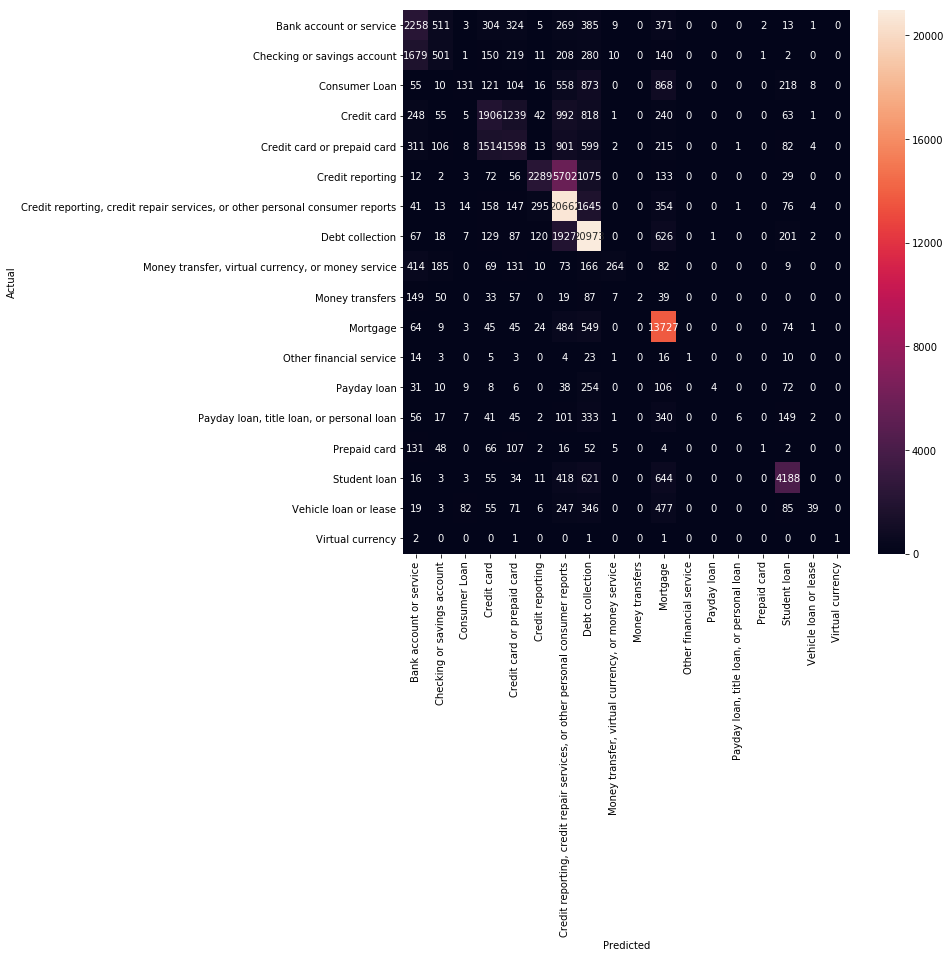

In [69]:
#Confusion Matrix
products_count_df = df.groupby('product').complaint.count().to_frame()
products_count_df.reset_index(level=0, inplace=True)
product_class_labels = array(products_count_df['product'].unique())

conf_mat = confusion_matrix(test_y, rf_preds)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=product_class_labels, yticklabels=product_class_labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

- Lot of values can be seen on the diagonal, which is good for the model. Upsampling would probably help our case.
- I also implemented a CNN Model with Keras using Keras Tokenizer. This isn't completely done yet. I'm still mentioning the code for your review.

In [ ]:
# Model 3: CNN using Keras
from keras.layers import Embedding
from keras.preprocessing.text import Tokenizer
NUM_WORDS = 20000
texts = train_df.complaints_untokenized
products_unique = vectorized_df['product'].unique()

dict_products = {}
for i, complaint in enumerate(products_unique):
    dict_products[complaint] = i
labels = vectorized_df['product'].apply(lambda x:dict_products[x])

vocab_lst_flat = [item for sublist in vocabulary_of_all_words for item in sublist]

EMBEDDING_DIM=300
vocabulary_size=min(len(word_index) + 1, NUM_WORDS)
embedding_layer = Embedding(vocabulary_size, EMBEDDING_DIM)

tokenizer = Tokenizer(num_words=NUM_WORDS,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'',
                      lower=True)
tokenizer.fit_on_texts(texts)
sequences_train = tokenizer.texts_to_sequences(texts)
sequences_valid=tokenizer.texts_to_sequences(val_df.complaints_untokenized)
word_index = tokenizer.word_index

    
train_df = train_df.drop(val_df.index)
# sequences_train = tokenizer.texts_to_sequences(texts) #train_df.drop('product', axis=1).values
# sequences_valid = val_df.drop('product', axis=1).values             
                    
size_train = len(train_x)
size_test = len(test_x)
output_labels_unique = np.asarray(sorted(list(set(labels))))

X_train = pad_sequences(sequences_train)
X_val = pad_sequences(sequences_valid,maxlen=X_train.shape[1]) #test
# convert into dummy representation of the output labels
y_train = to_categorical(np.asarray(labels[train_df.index]))
y_val = to_categorical(np.asarray(labels[val_df.index]))

In [ ]:
sequence_length = X_train.shape[1]
filter_sizes = [3,4,5]
num_filters = 100
drop = 0.5

output_dim = len(products_unique)

print('Shape of X train and X test tensors:', X_train.shape, X_val.shape)
print('Shape of label train and test tensors:', y_train.shape, y_val.shape)

In [ ]:
inputs = Input(shape=(sequence_length,))
embedding = embedding_layer(inputs)
reshape = Reshape((sequence_length, EMBEDDING_DIM, 1))(embedding)

conv_0 = Conv2D(num_filters, (filter_sizes[0], EMBEDDING_DIM), activation='relu', 
                                kernel_regularizer=regularizers.l2(0.01))(reshape)
conv_1 = Conv2D(num_filters, (filter_sizes[1], EMBEDDING_DIM), activation='relu', 
                                kernel_regularizer=regularizers.l2(0.01))(reshape)
conv_2 = Conv2D(num_filters, (filter_sizes[2], EMBEDDING_DIM), activation='relu', 
                                kernel_regularizer=regularizers.l2(0.01))(reshape)

maxpool_0 = MaxPooling2D((sequence_length - filter_sizes[0] + 1, 1), strides=(1,1))(conv_0)
maxpool_1 = MaxPooling2D((sequence_length - filter_sizes[1] + 1, 1), strides=(1,1))(conv_1)
maxpool_2 = MaxPooling2D((sequence_length - filter_sizes[2] + 1, 1), strides=(1,1))(conv_2)

merged_tensor = concatenate([maxpool_0, maxpool_1, maxpool_2], axis=1)
flatten = Flatten()(merged_tensor)
reshape = Reshape((3*num_filters,))(flatten)
dropout = Dropout(drop)(flatten)
output = Dense(units=output_dim, activation='softmax', kernel_regularizer=regularizers.l2(0.01))(dropout)

cnn_model = Model(inputs, output)
adam = Adam(lr=1e-3)
cnn_model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['acc'])
callbacks = [EarlyStopping(monitor='val_loss')]

In [ ]:
cnn_model.fit(X_train, y_train, batch_size=1000, epochs=10, verbose=1, validation_data=(X_val, y_val),
                callbacks=callbacks)

In [ ]:
# Predicting on the test set
sequences_test = test_x
X_test = pad_sequences(sequences_test, maxlen=X_train.shape[1])
cnn_preds = cnn_model.predict(X_test)
print("Predictions from CNN completed.")

In [ ]:
cnn_results = pd.DataFrame(data={"actual_label":test_y, "predicted_label":cnn_preds})
# Accuracy: wherever the labels were correctly predicted.
cnn_results['correctly_predicted'] = np.where(cnn_results['actual_label'] == cnn_results['predicted_label'], 
                                                1, 0)
cnn_accuracy = (naive_results['correctly_predicted'].sum()/cnn_results.shape[0])*100
print("Accuracy of the CNN Model is: {0:.2f}.".format(cnn_accuracy))

-----------------------------------------------------------------------------------------------------------------

## Conclusion

- The model that performed best was: RF with word2Vec feature embeddings. It gave an accuracy measure of: 65.30%. This was obtained with the word2Vec model made out of the the training set.
- Due to time constraints and even after taking a p2.xlarge instance, I wasn't able to run the code to completion for Random Forest with pre-trained word2Vec model of GoogleNews.
- The model was saved using:

        `pickle.dump(classifier, open('trained_models/best_model.sav', 'wb'))`

 to save the Random Forest classifier to storage for predictions with Flask. Thereafter, it was used to make predictions.

- I was able to derive the probabilities associated with these predictions as well. These have been displayed in the Flask application. 
- Given more resources such as GPU, I would have run this on the complete dataset using the pre-trained Google word2Vec + CNN, which I haven't been able to.

-----------------------------------------------------------------------------------------------------------------